In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2024-01-03 00:42:47.954486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2012'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(start_year), int(end_month), int(end_day))
t = (int(end_year)-int(start_year)+1)*(numOfDays(date1, date2)+1)

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
            list_of_file_names.append(all_file_names) # all days in month
elif int(start_year)<int(end_year):
    for i in range(int(start_year),int(end_year)+1,1):
            for m in range(int(start_month),int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+str(i)+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                month=[]
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
  
print(len(list_of_files))

8778


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010400.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010500.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010600.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010700.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010800.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010900.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011000.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011100.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011200.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011300.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011400.nc
14
/prj/

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
123
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
124
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
125
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060600.nc
126
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060700.nc
127
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060800.nc
128
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060900.nc
129
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061000.nc
130
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061100.nc
131
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061200.nc
132
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061300.nc
133
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061400.nc
134
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061500.nc
135
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061600.nc
136
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110400.nc
244
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
245
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
246
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
247
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110800.nc
248
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110900.nc
249
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111000.nc
250
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111100.nc
251
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111200.nc
252
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111300.nc
253
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111400.nc
254
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111500.nc
255
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111600.nc
256
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111700.nc
257
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_

364
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160500.nc
365
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160600.nc
366
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160700.nc
367
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160800.nc
368
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160900.nc
369
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161000.nc
370
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161100.nc
371
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161200.nc
372
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161300.nc
373
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161400.nc
374
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161500.nc
375
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161600.nc
376
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161700.nc
377
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161800.nc
378
/prj/nflics/hist_cores/2010/06/16/Hist_cores

486
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210700.nc
487
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210800.nc
488
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210900.nc
489
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211000.nc
490
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211100.nc
491
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211200.nc
492
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211300.nc
493
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211400.nc
494
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211500.nc
495
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211600.nc
496
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211700.nc
497
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211800.nc
498
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211900.nc
499
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212000.nc
500
/prj/nflics/hist_cores/2010/06/21/Hist_cores

/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260900.nc
609
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261000.nc
610
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261100.nc
611
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261200.nc
612
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261300.nc
613
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261400.nc
614
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261500.nc
615
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261600.nc
616
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261700.nc
617
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261800.nc
618
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261900.nc
619
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262000.nc
620
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262100.nc
621
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262200.nc
622
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_

730
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011100.nc
731
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011200.nc
732
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011300.nc
733
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011400.nc
734
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011500.nc
735
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011600.nc
736
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011700.nc
737
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011800.nc
738
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011900.nc
739
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012000.nc
740
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012100.nc
741
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012200.nc
742
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012300.nc
743
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020000.nc
744
/prj/nflics/hist_cores/2010/07/02/Hist_cores

853
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061400.nc
854
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061500.nc
855
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061600.nc
856
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061700.nc
857
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061800.nc
858
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061900.nc
859
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062000.nc
860
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062100.nc
861
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062200.nc
862
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062300.nc
863
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070000.nc
864
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070100.nc
865
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070200.nc
866
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070300.nc
867
/prj/nflics/hist_cores/2010/07/07/Hist_cores

/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111600.nc
976
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111700.nc
977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111800.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111900.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112000.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112100.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112200.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112300.nc
983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120000.nc
984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120100.nc
985
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120200.nc
986
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120300.nc
987
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120400.nc
988
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120500.nc
989
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_

1096
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161700.nc
1097
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161800.nc
1098
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161900.nc
1099
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162000.nc
1100
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162100.nc
1101
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162200.nc
1102
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162300.nc
1103
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170000.nc
1104
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170100.nc
1105
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170200.nc
1106
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170300.nc
1107
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170400.nc
1108
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170500.nc
1109
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170600.nc
1110
/prj/nflics/hist_cores/2010/0

1216
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211700.nc
1217
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211800.nc
1218
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211900.nc
1219
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212000.nc
1220
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212100.nc
1221
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212200.nc
1222
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212300.nc
1223
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220000.nc
1224
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220100.nc
1225
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220200.nc
1226
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220300.nc
1227
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220400.nc
1228
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220500.nc
1229
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220600.nc
1230
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261600.nc
1336
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261700.nc
1337
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261800.nc
1338
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261900.nc
1339
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262000.nc
1340
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262100.nc
1341
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262200.nc
1342
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262300.nc
1343
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270000.nc
1344
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270100.nc
1345
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270200.nc
1346
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270300.nc
1347
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270400.nc
1348
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270500.nc
1349
/prj/nflics/hist_cores/2010/07/27/

1455
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311600.nc
1456
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311700.nc
1457
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311800.nc
1458
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311900.nc
1459
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312000.nc
1460
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312100.nc
1461
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312200.nc
1462
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312300.nc
1463
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010000.nc
1464
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010100.nc
1465
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010200.nc
1466
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010300.nc
1467
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010400.nc
1468
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010500.nc
1469
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051600.nc
1576
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051700.nc
1577
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051800.nc
1578
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051900.nc
1579
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052000.nc
1580
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052100.nc
1581
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052200.nc
1582
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052300.nc
1583
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060000.nc
1584
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060100.nc
1585
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060200.nc
1586
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060300.nc
1587
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060400.nc
1588
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060500.nc
1589
/prj/nflics/hist_cores/2010/08/06/

/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101600.nc
1696
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101700.nc
1697
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101800.nc
1698
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101900.nc
1699
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102000.nc
1700
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102100.nc
1701
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102200.nc
1702
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102300.nc
1703
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110000.nc
1704
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110100.nc
1705
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110200.nc
1706
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110300.nc
1707
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110400.nc
1708
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110500.nc
1709
/prj/nflics/hist_cores/2010/08/11/

/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151600.nc
1816
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151700.nc
1817
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151800.nc
1818
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151900.nc
1819
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152000.nc
1820
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152100.nc
1821
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152200.nc
1822
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152300.nc
1823
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160000.nc
1824
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160100.nc
1825
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160200.nc
1826
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160300.nc
1827
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160400.nc
1828
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160500.nc
1829
/prj/nflics/hist_cores/2010/08/16/

1934
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201500.nc
1935
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201600.nc
1936
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201700.nc
1937
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201800.nc
1938
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201900.nc
1939
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202000.nc
1940
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202100.nc
1941
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202200.nc
1942
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202300.nc
1943
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210000.nc
1944
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210100.nc
1945
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210200.nc
1946
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210300.nc
1947
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210400.nc
1948
/prj/nflics/hist_cores/2010/0

2053
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251400.nc
2054
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251500.nc
2055
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251600.nc
2056
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251700.nc
2057
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251800.nc
2058
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251900.nc
2059
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252000.nc
2060
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252100.nc
2061
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252200.nc
2062
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252300.nc
2063
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260000.nc
2064
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260100.nc
2065
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260200.nc
2066
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260300.nc
2067
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301400.nc
2174
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301500.nc
2175
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301600.nc
2176
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301700.nc
2177
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301800.nc
2178
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301900.nc
2179
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302000.nc
2180
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302100.nc
2181
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302200.nc
2182
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302300.nc
2183
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310000.nc
2184
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310100.nc
2185
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310200.nc
2186
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310300.nc
2187
/prj/nflics/hist_cores/2010/08/31/

/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041400.nc
2294
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041500.nc
2295
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041600.nc
2296
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041700.nc
2297
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041800.nc
2298
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041900.nc
2299
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042000.nc
2300
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042100.nc
2301
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042200.nc
2302
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042300.nc
2303
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050000.nc
2304
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050100.nc
2305
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050200.nc
2306
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050300.nc
2307
/prj/nflics/hist_cores/2010/09/05/

/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091300.nc
2413
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091400.nc
2414
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091500.nc
2415
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091600.nc
2416
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091700.nc
2417
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091800.nc
2418
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091900.nc
2419
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092000.nc
2420
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092100.nc
2421
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092200.nc
2422
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092300.nc
2423
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100000.nc
2424
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100100.nc
2425
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100200.nc
2426
/prj/nflics/hist_cores/2010/09/10/

2533
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141400.nc
2534
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141500.nc
2535
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141600.nc
2536
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141700.nc
2537
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141800.nc
2538
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141900.nc
2539
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142000.nc
2540
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142100.nc
2541
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142200.nc
2542
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142300.nc
2543
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150000.nc
2544
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150100.nc
2545
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150200.nc
2546
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150300.nc
2547
/prj/nflics/hist_cores/2010/0

2652
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191300.nc
2653
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191400.nc
2654
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191500.nc
2655
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191600.nc
2656
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191700.nc
2657
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191800.nc
2658
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191900.nc
2659
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192000.nc
2660
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192100.nc
2661
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192200.nc
2662
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192300.nc
2663
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200000.nc
2664
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200100.nc
2665
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200200.nc
2666
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241200.nc
2772
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241300.nc
2773
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241400.nc
2774
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241500.nc
2775
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241600.nc
2776
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241700.nc
2777
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241800.nc
2778
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241900.nc
2779
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242000.nc
2780
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242100.nc
2781
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242200.nc
2782
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242300.nc
2783
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250000.nc
2784
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250100.nc
2785
/prj/nflics/hist_cores/2010/09/25/

/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291100.nc
2891
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291200.nc
2892
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291300.nc
2893
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291400.nc
2894
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291500.nc
2895
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291600.nc
2896
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291700.nc
2897
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291800.nc
2898
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291900.nc
2899
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292000.nc
2900
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292100.nc
2901
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292200.nc
2902
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292300.nc
2903
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300000.nc
2904
/prj/nflics/hist_cores/2010/09/30/

/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041200.nc
3012
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041300.nc
3013
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041400.nc
3014
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041500.nc
3015
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041600.nc
3016
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041700.nc
3017
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041800.nc
3018
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041900.nc
3019
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042000.nc
3020
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042100.nc
3021
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042200.nc
3022
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042300.nc
3023
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050000.nc
3024
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050100.nc
3025
/prj/nflics/hist_cores/2011/06/05/

/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091200.nc
3132
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091300.nc
3133
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091400.nc
3134
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091500.nc
3135
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091600.nc
3136
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091700.nc
3137
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091800.nc
3138
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091900.nc
3139
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092000.nc
3140
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092100.nc
3141
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092200.nc
3142
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092300.nc
3143
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100000.nc
3144
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100100.nc
3145
/prj/nflics/hist_cores/2011/06/10/

3252
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141300.nc
3253
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141400.nc
3254
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141500.nc
3255
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141600.nc
3256
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141700.nc
3257
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141800.nc
3258
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141900.nc
3259
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142000.nc
3260
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142100.nc
3261
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142200.nc
3262
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142300.nc
3263
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150000.nc
3264
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150100.nc
3265
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150200.nc
3266
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191400.nc
3374
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191500.nc
3375
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191600.nc
3376
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191700.nc
3377
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191800.nc
3378
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191900.nc
3379
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192000.nc
3380
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192100.nc
3381
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192200.nc
3382
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192300.nc
3383
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200000.nc
3384
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200100.nc
3385
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200200.nc
3386
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200300.nc
3387
/prj/nflics/hist_cores/2011/06/20/

/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241600.nc
3496
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241700.nc
3497
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241800.nc
3498
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241900.nc
3499
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242000.nc
3500
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242100.nc
3501
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242200.nc
3502
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242300.nc
3503
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250000.nc
3504
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250100.nc
3505
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250200.nc
3506
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250300.nc
3507
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250400.nc
3508
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250500.nc
3509
/prj/nflics/hist_cores/2011/06/25/

/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291700.nc
3617
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291800.nc
3618
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291900.nc
3619
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292000.nc
3620
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292100.nc
3621
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292200.nc
3622
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292300.nc
3623
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300000.nc
3624
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300100.nc
3625
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300200.nc
3626
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300300.nc
3627
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300400.nc
3628
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300500.nc
3629
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300600.nc
3630
/prj/nflics/hist_cores/2011/06/30/

/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041800.nc
3738
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041900.nc
3739
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042000.nc
3740
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042100.nc
3741
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042200.nc
3742
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042300.nc
3743
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050000.nc
3744
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050100.nc
3745
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050200.nc
3746
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050300.nc
3747
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050400.nc
3748
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050500.nc
3749
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050600.nc
3750
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050700.nc
3751
/prj/nflics/hist_cores/2011/07/05/

/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092000.nc
3860
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092100.nc
3861
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092200.nc
3862
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092300.nc
3863
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100000.nc
3864
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100100.nc
3865
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100200.nc
3866
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100300.nc
3867
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100400.nc
3868
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100500.nc
3869
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100600.nc
3870
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100700.nc
3871
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100800.nc
3872
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100900.nc
3873
/prj/nflics/hist_cores/2011/07/10/

/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142100.nc
3981
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142200.nc
3982
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142300.nc
3983
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150000.nc
3984
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150100.nc
3985
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150200.nc
3986
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150300.nc
3987
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150400.nc
3988
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150500.nc
3989
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150600.nc
3990
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150700.nc
3991
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150800.nc
3992
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150900.nc
3993
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107151000.nc
3994
/prj/nflics/hist_cores/2011/07/15/

/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192200.nc
4102
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192300.nc
4103
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200000.nc
4104
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200100.nc
4105
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200200.nc
4106
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200300.nc
4107
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200400.nc
4108
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200500.nc
4109
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200600.nc
4110
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200700.nc
4111
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200800.nc
4112
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200900.nc
4113
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107201000.nc
4114
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107201100.nc
4115
/prj/nflics/hist_cores/2011/07/20/

/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242300.nc
4223
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250000.nc
4224
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250100.nc
4225
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250200.nc
4226
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250300.nc
4227
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250400.nc
4228
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250500.nc
4229
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250600.nc
4230
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250700.nc
4231
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250800.nc
4232
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250900.nc
4233
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107251000.nc
4234
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107251100.nc
4235
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107251200.nc
4236
/prj/nflics/hist_cores/2011/07/25/

4342
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292300.nc
4343
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300000.nc
4344
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300100.nc
4345
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300200.nc
4346
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300300.nc
4347
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300400.nc
4348
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300500.nc
4349
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300600.nc
4350
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300700.nc
4351
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300800.nc
4352
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300900.nc
4353
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107301000.nc
4354
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107301100.nc
4355
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107301200.nc
4356
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032200.nc
4462
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032300.nc
4463
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040000.nc
4464
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040100.nc
4465
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040200.nc
4466
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040300.nc
4467
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040400.nc
4468
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040500.nc
4469
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040600.nc
4470
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040700.nc
4471
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040800.nc
4472
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108040900.nc
4473
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108041000.nc
4474
/prj/nflics/hist_cores/2011/08/04/Hist_cores_wa_201108041100.nc
4475
/prj/nflics/hist_cores/2011/08/04/

4582
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108082300.nc
4583
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090000.nc
4584
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090100.nc
4585
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090200.nc
4586
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090300.nc
4587
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090400.nc
4588
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090500.nc
4589
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090600.nc
4590
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090700.nc
4591
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090800.nc
4592
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090900.nc
4593
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108091000.nc
4594
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108091100.nc
4595
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108091200.nc
4596
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140000.nc
4704
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140100.nc
4705
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140200.nc
4706
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140300.nc
4707
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140400.nc
4708
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140500.nc
4709
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140600.nc
4710
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140700.nc
4711
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140800.nc
4712
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108140900.nc
4713
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108141000.nc
4714
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108141100.nc
4715
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108141200.nc
4716
/prj/nflics/hist_cores/2011/08/14/Hist_cores_wa_201108141300.nc
4717
/prj/nflics/hist_cores/2011/08/14/

/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190100.nc
4825
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190200.nc
4826
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190300.nc
4827
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190400.nc
4828
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190500.nc
4829
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190600.nc
4830
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190700.nc
4831
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190800.nc
4832
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108190900.nc
4833
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108191000.nc
4834
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108191100.nc
4835
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108191200.nc
4836
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108191300.nc
4837
/prj/nflics/hist_cores/2011/08/19/Hist_cores_wa_201108191400.nc
4838
/prj/nflics/hist_cores/2011/08/19/

/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240200.nc
4946
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240300.nc
4947
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240400.nc
4948
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240500.nc
4949
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240600.nc
4950
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240700.nc
4951
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240800.nc
4952
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108240900.nc
4953
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241000.nc
4954
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241100.nc
4955
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241200.nc
4956
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241300.nc
4957
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241400.nc
4958
/prj/nflics/hist_cores/2011/08/24/Hist_cores_wa_201108241500.nc
4959
/prj/nflics/hist_cores/2011/08/24/

/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290100.nc
5065
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290200.nc
5066
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290300.nc
5067
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290400.nc
5068
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290500.nc
5069
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290600.nc
5070
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290700.nc
5071
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290800.nc
5072
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108290900.nc
5073
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108291000.nc
5074
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108291100.nc
5075
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108291200.nc
5076
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108291300.nc
5077
/prj/nflics/hist_cores/2011/08/29/Hist_cores_wa_201108291400.nc
5078
/prj/nflics/hist_cores/2011/08/29/

/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030200.nc
5186
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030300.nc
5187
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030400.nc
5188
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030500.nc
5189
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030600.nc
5190
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030700.nc
5191
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030800.nc
5192
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109030900.nc
5193
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031000.nc
5194
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031100.nc
5195
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031200.nc
5196
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031300.nc
5197
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031400.nc
5198
/prj/nflics/hist_cores/2011/09/03/Hist_cores_wa_201109031500.nc
5199
/prj/nflics/hist_cores/2011/09/03/

/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080200.nc
5306
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080300.nc
5307
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080400.nc
5308
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080500.nc
5309
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080600.nc
5310
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080700.nc
5311
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080800.nc
5312
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109080900.nc
5313
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081000.nc
5314
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081100.nc
5315
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081200.nc
5316
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081300.nc
5317
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081400.nc
5318
/prj/nflics/hist_cores/2011/09/08/Hist_cores_wa_201109081500.nc
5319
/prj/nflics/hist_cores/2011/09/08/

/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130200.nc
5426
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130300.nc
5427
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130400.nc
5428
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130500.nc
5429
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130600.nc
5430
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130700.nc
5431
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130800.nc
5432
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109130900.nc
5433
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131000.nc
5434
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131100.nc
5435
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131200.nc
5436
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131300.nc
5437
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131400.nc
5438
/prj/nflics/hist_cores/2011/09/13/Hist_cores_wa_201109131500.nc
5439
/prj/nflics/hist_cores/2011/09/13/

/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180100.nc
5545
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180200.nc
5546
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180300.nc
5547
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180400.nc
5548
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180500.nc
5549
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180600.nc
5550
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180700.nc
5551
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180800.nc
5552
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109180900.nc
5553
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109181000.nc
5554
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109181100.nc
5555
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109181200.nc
5556
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109181300.nc
5557
/prj/nflics/hist_cores/2011/09/18/Hist_cores_wa_201109181400.nc
5558
/prj/nflics/hist_cores/2011/09/18/

/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230300.nc
5667
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230400.nc
5668
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230500.nc
5669
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230600.nc
5670
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230700.nc
5671
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230800.nc
5672
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109230900.nc
5673
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231000.nc
5674
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231100.nc
5675
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231200.nc
5676
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231300.nc
5677
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231400.nc
5678
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231500.nc
5679
/prj/nflics/hist_cores/2011/09/23/Hist_cores_wa_201109231600.nc
5680
/prj/nflics/hist_cores/2011/09/23/

/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280400.nc
5788
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280500.nc
5789
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280600.nc
5790
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280700.nc
5791
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280800.nc
5792
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109280900.nc
5793
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281000.nc
5794
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281100.nc
5795
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281200.nc
5796
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281300.nc
5797
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281400.nc
5798
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281500.nc
5799
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281600.nc
5800
/prj/nflics/hist_cores/2011/09/28/Hist_cores_wa_201109281700.nc
5801
/prj/nflics/hist_cores/2011/09/28/

/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030400.nc
5908
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030500.nc
5909
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030600.nc
5910
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030700.nc
5911
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030800.nc
5912
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206030900.nc
5913
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031000.nc
5914
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031100.nc
5915
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031200.nc
5916
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031300.nc
5917
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031400.nc
5918
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031500.nc
5919
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031600.nc
5920
/prj/nflics/hist_cores/2012/06/03/Hist_cores_wa_201206031700.nc
5921
/prj/nflics/hist_cores/2012/06/03/

/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080400.nc
6028
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080500.nc
6029
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080600.nc
6030
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080700.nc
6031
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080800.nc
6032
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206080900.nc
6033
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081000.nc
6034
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081100.nc
6035
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081200.nc
6036
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081300.nc
6037
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081400.nc
6038
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081500.nc
6039
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081600.nc
6040
/prj/nflics/hist_cores/2012/06/08/Hist_cores_wa_201206081700.nc
6041
/prj/nflics/hist_cores/2012/06/08/

/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206130500.nc
6149
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206130600.nc
6150
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206130700.nc
6151
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206130800.nc
6152
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206130900.nc
6153
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131000.nc
6154
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131100.nc
6155
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131200.nc
6156
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131300.nc
6157
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131400.nc
6158
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131500.nc
6159
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131600.nc
6160
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131700.nc
6161
/prj/nflics/hist_cores/2012/06/13/Hist_cores_wa_201206131800.nc
6162
/prj/nflics/hist_cores/2012/06/13/

/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206180500.nc
6269
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206180600.nc
6270
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206180700.nc
6271
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206180800.nc
6272
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206180900.nc
6273
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181000.nc
6274
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181100.nc
6275
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181200.nc
6276
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181300.nc
6277
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181400.nc
6278
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181500.nc
6279
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181600.nc
6280
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181700.nc
6281
/prj/nflics/hist_cores/2012/06/18/Hist_cores_wa_201206181800.nc
6282
/prj/nflics/hist_cores/2012/06/18/

/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206230600.nc
6390
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206230700.nc
6391
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206230800.nc
6392
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206230900.nc
6393
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231000.nc
6394
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231100.nc
6395
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231200.nc
6396
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231300.nc
6397
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231400.nc
6398
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231500.nc
6399
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231600.nc
6400
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231700.nc
6401
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231800.nc
6402
/prj/nflics/hist_cores/2012/06/23/Hist_cores_wa_201206231900.nc
6403
/prj/nflics/hist_cores/2012/06/23/

/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206280600.nc
6510
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206280700.nc
6511
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206280800.nc
6512
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206280900.nc
6513
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281000.nc
6514
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281100.nc
6515
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281200.nc
6516
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281300.nc
6517
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281400.nc
6518
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281500.nc
6519
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281600.nc
6520
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281700.nc
6521
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281800.nc
6522
/prj/nflics/hist_cores/2012/06/28/Hist_cores_wa_201206281900.nc
6523
/prj/nflics/hist_cores/2012/06/28/

/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207030700.nc
6631
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207030800.nc
6632
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207030900.nc
6633
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031000.nc
6634
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031100.nc
6635
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031200.nc
6636
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031300.nc
6637
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031400.nc
6638
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031500.nc
6639
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031600.nc
6640
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031700.nc
6641
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031800.nc
6642
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207031900.nc
6643
/prj/nflics/hist_cores/2012/07/03/Hist_cores_wa_201207032000.nc
6644
/prj/nflics/hist_cores/2012/07/03/

/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081300.nc
6751
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081400.nc
6752
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081500.nc
6753
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081600.nc
6754
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081700.nc
6755
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081800.nc
6756
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207081900.nc
6757
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207082000.nc
6758
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207082100.nc
6759
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207082200.nc
6760
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207082300.nc
6761
/prj/nflics/hist_cores/2012/07/09/Hist_cores_wa_201207090000.nc
6762
/prj/nflics/hist_cores/2012/07/09/Hist_cores_wa_201207090100.nc
6763
/prj/nflics/hist_cores/2012/07/09/Hist_cores_wa_201207090200.nc
6764
/prj/nflics/hist_cores/2012/07/09/

/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131300.nc
6871
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131400.nc
6872
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131500.nc
6873
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131600.nc
6874
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131700.nc
6875
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131800.nc
6876
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207131900.nc
6877
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207132000.nc
6878
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207132100.nc
6879
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207132200.nc
6880
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207132300.nc
6881
/prj/nflics/hist_cores/2012/07/14/Hist_cores_wa_201207140000.nc
6882
/prj/nflics/hist_cores/2012/07/14/Hist_cores_wa_201207140100.nc
6883
/prj/nflics/hist_cores/2012/07/14/Hist_cores_wa_201207140200.nc
6884
/prj/nflics/hist_cores/2012/07/14/

/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181300.nc
6991
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181400.nc
6992
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181500.nc
6993
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181600.nc
6994
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181700.nc
6995
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181800.nc
6996
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207181900.nc
6997
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207182000.nc
6998
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207182100.nc
6999
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207182200.nc
7000
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207182300.nc
7001
/prj/nflics/hist_cores/2012/07/19/Hist_cores_wa_201207190000.nc
7002
/prj/nflics/hist_cores/2012/07/19/Hist_cores_wa_201207190100.nc
7003
/prj/nflics/hist_cores/2012/07/19/Hist_cores_wa_201207190200.nc
7004
/prj/nflics/hist_cores/2012/07/19/

/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231300.nc
7111
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231400.nc
7112
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231500.nc
7113
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231600.nc
7114
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231700.nc
7115
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231800.nc
7116
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207231900.nc
7117
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207232000.nc
7118
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207232100.nc
7119
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207232200.nc
7120
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207232300.nc
7121
/prj/nflics/hist_cores/2012/07/24/Hist_cores_wa_201207240000.nc
7122
/prj/nflics/hist_cores/2012/07/24/Hist_cores_wa_201207240100.nc
7123
/prj/nflics/hist_cores/2012/07/24/Hist_cores_wa_201207240200.nc
7124
/prj/nflics/hist_cores/2012/07/24/

/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281300.nc
7231
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281400.nc
7232
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281500.nc
7233
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281600.nc
7234
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281700.nc
7235
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281800.nc
7236
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207281900.nc
7237
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207282000.nc
7238
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207282100.nc
7239
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207282200.nc
7240
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207282300.nc
7241
/prj/nflics/hist_cores/2012/07/29/Hist_cores_wa_201207290000.nc
7242
/prj/nflics/hist_cores/2012/07/29/Hist_cores_wa_201207290100.nc
7243
/prj/nflics/hist_cores/2012/07/29/Hist_cores_wa_201207290200.nc
7244
/prj/nflics/hist_cores/2012/07/29/

/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021400.nc
7352
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021500.nc
7353
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021600.nc
7354
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021700.nc
7355
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021800.nc
7356
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208021900.nc
7357
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208022000.nc
7358
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208022100.nc
7359
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208022200.nc
7360
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208022300.nc
7361
/prj/nflics/hist_cores/2012/08/03/Hist_cores_wa_201208030000.nc
7362
/prj/nflics/hist_cores/2012/08/03/Hist_cores_wa_201208030100.nc
7363
/prj/nflics/hist_cores/2012/08/03/Hist_cores_wa_201208030200.nc
7364
/prj/nflics/hist_cores/2012/08/03/Hist_cores_wa_201208030300.nc
7365
/prj/nflics/hist_cores/2012/08/03/

/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071400.nc
7472
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071500.nc
7473
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071600.nc
7474
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071700.nc
7475
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071800.nc
7476
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208071900.nc
7477
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208072000.nc
7478
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208072100.nc
7479
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208072200.nc
7480
/prj/nflics/hist_cores/2012/08/07/Hist_cores_wa_201208072300.nc
7481
/prj/nflics/hist_cores/2012/08/08/Hist_cores_wa_201208080000.nc
7482
/prj/nflics/hist_cores/2012/08/08/Hist_cores_wa_201208080100.nc
7483
/prj/nflics/hist_cores/2012/08/08/Hist_cores_wa_201208080200.nc
7484
/prj/nflics/hist_cores/2012/08/08/Hist_cores_wa_201208080300.nc
7485
/prj/nflics/hist_cores/2012/08/08/

/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121400.nc
7592
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121500.nc
7593
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121600.nc
7594
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121700.nc
7595
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121800.nc
7596
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208121900.nc
7597
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208122000.nc
7598
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208122100.nc
7599
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208122200.nc
7600
/prj/nflics/hist_cores/2012/08/12/Hist_cores_wa_201208122300.nc
7601
/prj/nflics/hist_cores/2012/08/13/Hist_cores_wa_201208130000.nc
7602
/prj/nflics/hist_cores/2012/08/13/Hist_cores_wa_201208130100.nc
7603
/prj/nflics/hist_cores/2012/08/13/Hist_cores_wa_201208130200.nc
7604
/prj/nflics/hist_cores/2012/08/13/Hist_cores_wa_201208130300.nc
7605
/prj/nflics/hist_cores/2012/08/13/

7712
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208171500.nc
7713
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208171600.nc
7714
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208171700.nc
7715
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208171800.nc
7716
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208171900.nc
7717
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208172000.nc
7718
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208172100.nc
7719
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208172200.nc
7720
/prj/nflics/hist_cores/2012/08/17/Hist_cores_wa_201208172300.nc
7721
/prj/nflics/hist_cores/2012/08/18/Hist_cores_wa_201208180000.nc
7722
/prj/nflics/hist_cores/2012/08/18/Hist_cores_wa_201208180100.nc
7723
/prj/nflics/hist_cores/2012/08/18/Hist_cores_wa_201208180200.nc
7724
/prj/nflics/hist_cores/2012/08/18/Hist_cores_wa_201208180300.nc
7725
/prj/nflics/hist_cores/2012/08/18/Hist_cores_wa_201208180400.nc
7726
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221400.nc
7832
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221500.nc
7833
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221600.nc
7834
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221700.nc
7835
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221800.nc
7836
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208221900.nc
7837
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208222000.nc
7838
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208222100.nc
7839
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208222200.nc
7840
/prj/nflics/hist_cores/2012/08/22/Hist_cores_wa_201208222300.nc
7841
/prj/nflics/hist_cores/2012/08/23/Hist_cores_wa_201208230000.nc
7842
/prj/nflics/hist_cores/2012/08/23/Hist_cores_wa_201208230100.nc
7843
/prj/nflics/hist_cores/2012/08/23/Hist_cores_wa_201208230200.nc
7844
/prj/nflics/hist_cores/2012/08/23/Hist_cores_wa_201208230300.nc
7845
/prj/nflics/hist_cores/2012/08/23/

/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208271600.nc
7954
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208271700.nc
7955
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208271800.nc
7956
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208271900.nc
7957
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208272000.nc
7958
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208272100.nc
7959
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208272200.nc
7960
/prj/nflics/hist_cores/2012/08/27/Hist_cores_wa_201208272300.nc
7961
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280000.nc
7962
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280100.nc
7963
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280200.nc
7964
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280300.nc
7965
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280400.nc
7966
/prj/nflics/hist_cores/2012/08/28/Hist_cores_wa_201208280500.nc
7967
/prj/nflics/hist_cores/2012/08/28/

/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209011700.nc
8075
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209011800.nc
8076
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209011900.nc
8077
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209012000.nc
8078
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209012100.nc
8079
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209012200.nc
8080
/prj/nflics/hist_cores/2012/09/01/Hist_cores_wa_201209012300.nc
8081
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020000.nc
8082
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020100.nc
8083
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020200.nc
8084
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020300.nc
8085
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020400.nc
8086
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020500.nc
8087
/prj/nflics/hist_cores/2012/09/02/Hist_cores_wa_201209020600.nc
8088
/prj/nflics/hist_cores/2012/09/02/

/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209061700.nc
8195
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209061800.nc
8196
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209061900.nc
8197
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209062000.nc
8198
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209062100.nc
8199
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209062200.nc
8200
/prj/nflics/hist_cores/2012/09/06/Hist_cores_wa_201209062300.nc
8201
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070000.nc
8202
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070100.nc
8203
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070200.nc
8204
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070300.nc
8205
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070400.nc
8206
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070500.nc
8207
/prj/nflics/hist_cores/2012/09/07/Hist_cores_wa_201209070600.nc
8208
/prj/nflics/hist_cores/2012/09/07/

8315
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209111800.nc
8316
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209111900.nc
8317
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209112000.nc
8318
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209112100.nc
8319
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209112200.nc
8320
/prj/nflics/hist_cores/2012/09/11/Hist_cores_wa_201209112300.nc
8321
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120000.nc
8322
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120100.nc
8323
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120200.nc
8324
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120300.nc
8325
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120400.nc
8326
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120500.nc
8327
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120600.nc
8328
/prj/nflics/hist_cores/2012/09/12/Hist_cores_wa_201209120700.nc
8329
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209161700.nc
8435
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209161800.nc
8436
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209161900.nc
8437
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209162000.nc
8438
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209162100.nc
8439
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209162200.nc
8440
/prj/nflics/hist_cores/2012/09/16/Hist_cores_wa_201209162300.nc
8441
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170000.nc
8442
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170100.nc
8443
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170200.nc
8444
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170300.nc
8445
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170400.nc
8446
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170500.nc
8447
/prj/nflics/hist_cores/2012/09/17/Hist_cores_wa_201209170600.nc
8448
/prj/nflics/hist_cores/2012/09/17/

/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209211700.nc
8555
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209211800.nc
8556
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209211900.nc
8557
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209212000.nc
8558
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209212100.nc
8559
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209212200.nc
8560
/prj/nflics/hist_cores/2012/09/21/Hist_cores_wa_201209212300.nc
8561
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220000.nc
8562
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220100.nc
8563
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220200.nc
8564
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220300.nc
8565
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220400.nc
8566
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220500.nc
8567
/prj/nflics/hist_cores/2012/09/22/Hist_cores_wa_201209220600.nc
8568
/prj/nflics/hist_cores/2012/09/22/

8676
/prj/nflics/hist_cores/2012/09/26/Hist_cores_wa_201209261900.nc
8677
/prj/nflics/hist_cores/2012/09/26/Hist_cores_wa_201209262000.nc
8678
/prj/nflics/hist_cores/2012/09/26/Hist_cores_wa_201209262100.nc
8679
/prj/nflics/hist_cores/2012/09/26/Hist_cores_wa_201209262200.nc
8680
/prj/nflics/hist_cores/2012/09/26/Hist_cores_wa_201209262300.nc
8681
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270000.nc
8682
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270100.nc
8683
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270200.nc
8684
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270300.nc
8685
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270400.nc
8686
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270500.nc
8687
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270600.nc
8688
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270700.nc
8689
/prj/nflics/hist_cores/2012/09/27/Hist_cores_wa_201209270800.nc
8690
/prj/nflics/hist_cores/2012/0

In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


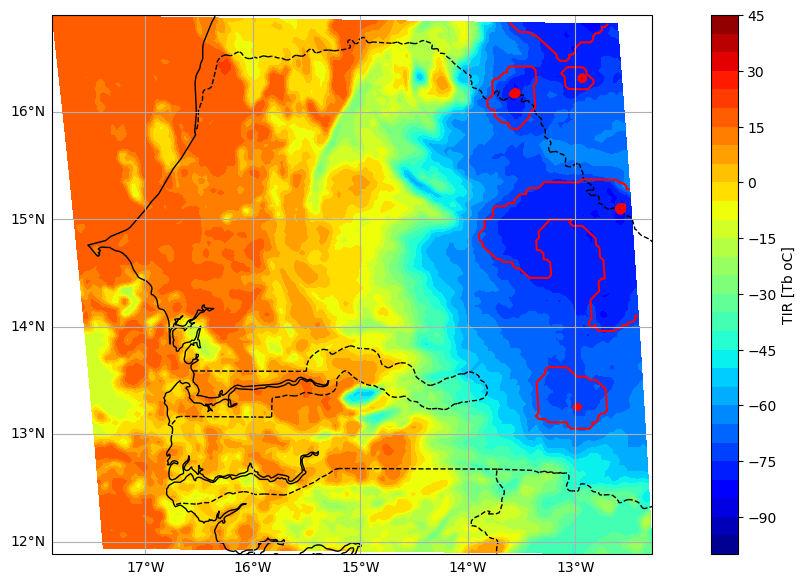

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [11]:
# input data- cores_t_0: 
# starting at 
num_frames= 1   #8  # previous 2 hours of images to predict 1 hr later
t0= 0  #1   #*4 # # 1hr  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]



In [12]:
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
ind = np.where(cores_t_0>0)
cores_t_0[ind] = 1

#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))


In [13]:
# open a file, where you stored the pickled data
#file = open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#hist_cores_t_0= data[2]
#cores_t_plus_xhr= data[3]

In [14]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)


(8783, 128, 128)
(8783, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


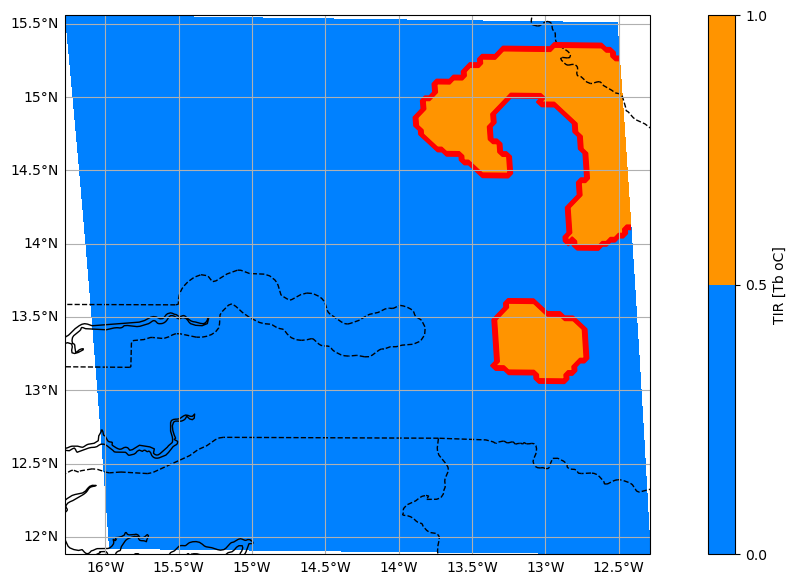

In [15]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores_t_0[day,:,:], colors='r')
#ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], colors='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [16]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_2hr_back_1hr_forward.pkl', 'wb') as file: 
          #pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [17]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [18]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [19]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 1  27264     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 8  6944      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 8  32   

In [20]:
num_frames= 8   #24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 100
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data   - cores already 0-1
#x_normalize_factor = np.max(x_train)
#x_train = x_train/x_normalize_factor
#x_val = x_val/x_normalize_factor


In [21]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(997, 8, 128, 128, 1)
(100, 8, 128, 128, 1)


In [22]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10   #10 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
250/250 [==============================] - 441s 2s/step - loss: 0.1007 - val_loss: 0.6081 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - 438s 2s/step - loss: 0.0166 - val_loss: 0.5165 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - 439s 2s/step - loss: 0.0156 - val_loss: 0.0317 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - 438s 2s/step - loss: 0.0151 - val_loss: 0.0210 - lr: 0.0010
Epoch 5/10
250/250 [==============================] - 438s 2s/step - loss: 0.0147 - val_loss: 0.0246 - lr: 0.0010
Epoch 6/10
250/250 [==============================] - 439s 2s/step - loss: 0.0145 - val_loss: 0.0222 - lr: 0.0010
Epoch 7/10
250/250 [==============================] - 439s 2s/step - loss: 0.0141 - val_loss: 0.0195 - lr: 0.0010
Epoch 8/10
250/250 [==============================] - 439s 2s/step - loss: 0.0138 - val_loss: 0.0191 - lr: 0.0010
Epoch 9/10
250/250 [==============================] - 438s 2s/step - loss: 0.0135 - val_

In [23]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_1hr_forward.pkl', 'wb') as file: 
    #pickle.dump(model, file) 
        

In [24]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [25]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
# all_frames=np.zeros((50,image_height,image_width, num_channels))

# for b in range(0,51,1):
batch_number = 25   #99 #25 #50
frames = x_val[batch_number,0:4,:,:,:] # 
#original_frames = x_val[batch_number,4:,:,:,0] # 
original_frames = y_val[batch_number,3:7,:,:,0] # 
pred_frames = np.zeros(frames.shape[:-1])
pred_frames = np.expand_dims(pred_frames, axis=-1)


# Predict a new set of 4 frames.
for i in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # Extend the set of prediction frames.
   # frames = np.concatenate((frames, predicted_frame), axis=0)
    pred_frames[i,:,:,:] =  predicted_frame


1/1 [==============================] - 0s 37ms/step


In [27]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [28]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


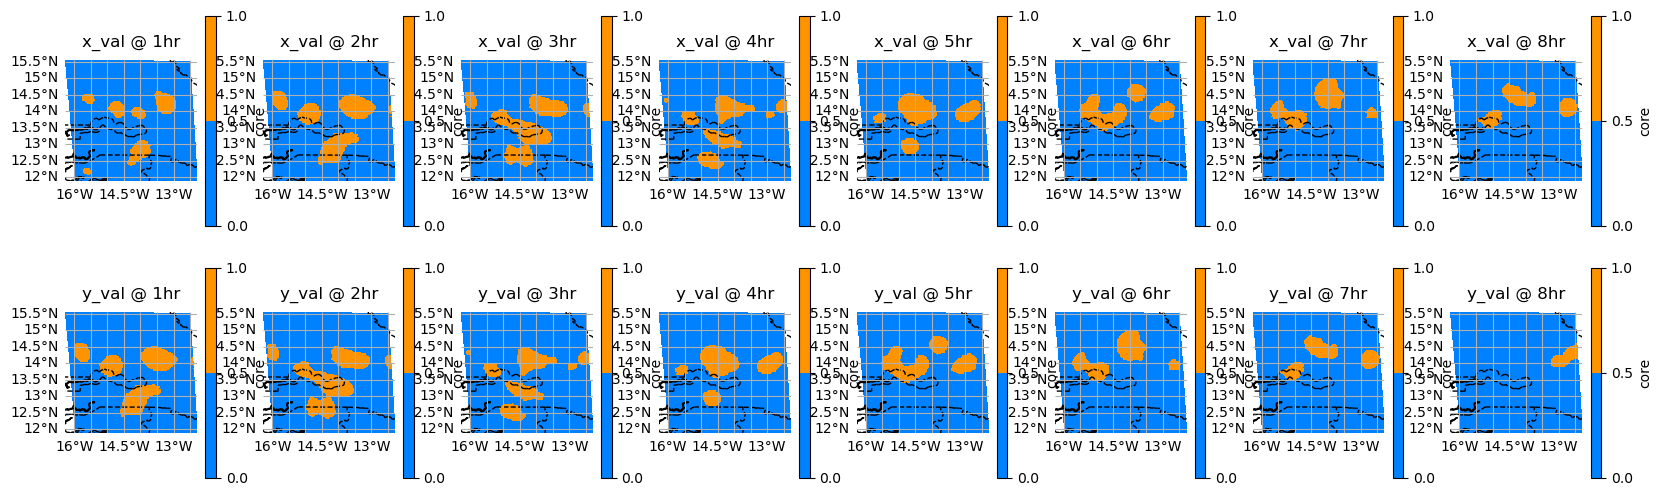

In [29]:
#x_val, y_val
#frames = x_val[batch_number,0:4,:,:,:] # 
#data = np.zeros((day,image_height,image_width))
#for x in range(0,8,1):
    #data[x] = np.squeeze(y_val[batch_number,x,:,:,0])
#batch_number= 25   #25        
#levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
levels_custom=[[0, 0.5,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 8, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(x_val[batch_number,idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"x_val @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(y_val[batch_number,idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"y_val @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()

In [30]:
print(frames.shape)
print(original_frames.shape)
print(pred_frames.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
#print((ind))

(4, 128, 128, 1)
(4, 128, 128)
(4, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


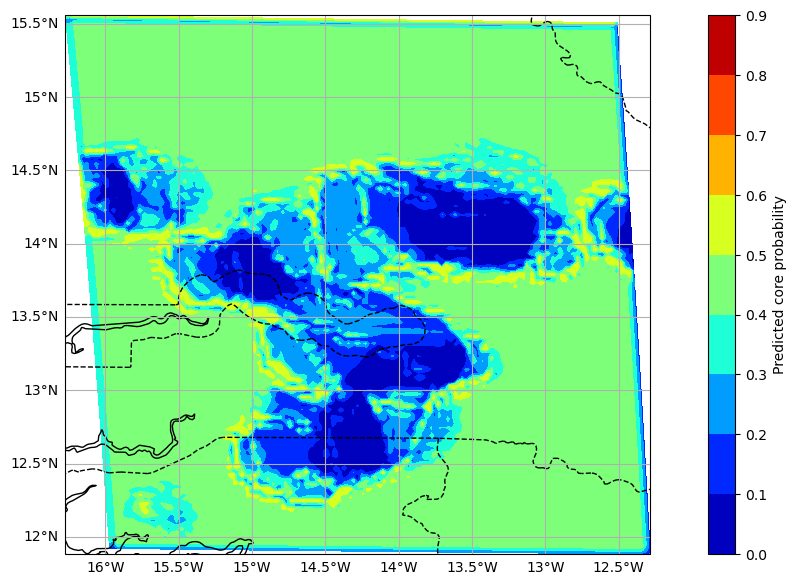

In [31]:
day = 0 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
#draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,0.75,1], cbar_label='Predicted core probability', cmap='jet')
draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=np.arange(0,1,0.1), cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


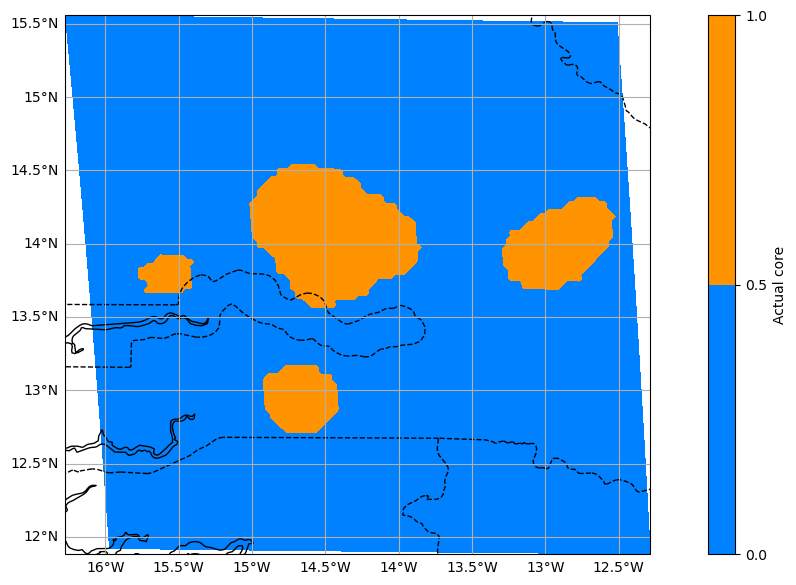

In [32]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[day,:,:]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

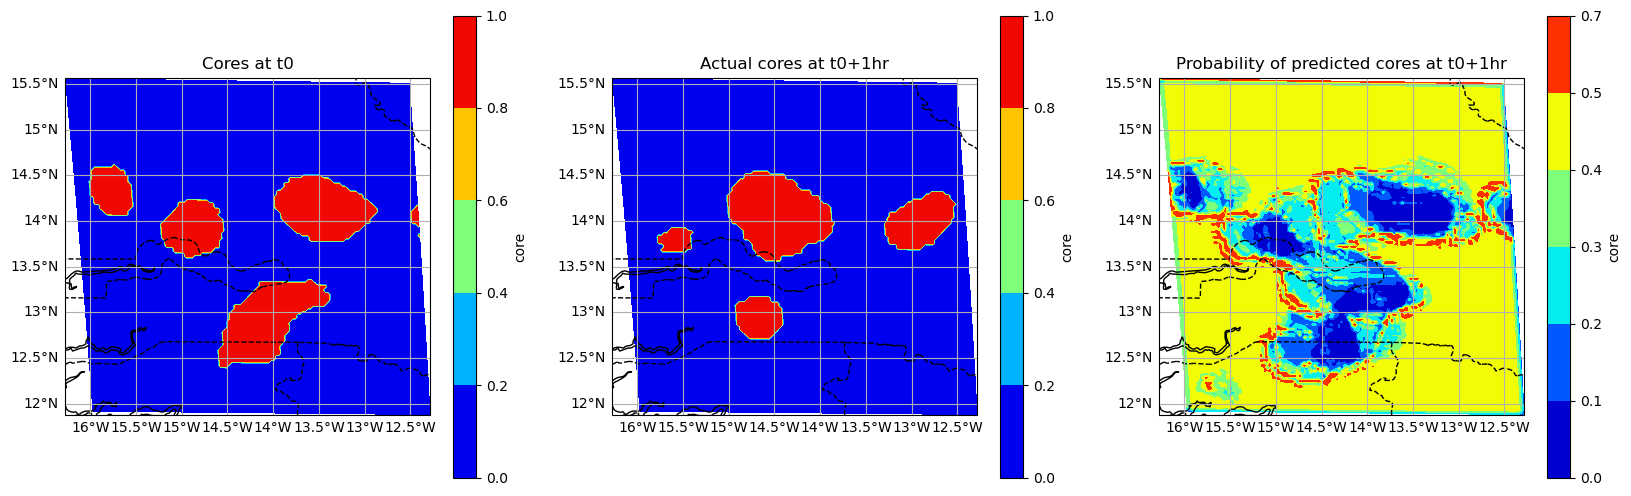

In [33]:
day = 3-2
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:])
data[2] = np.squeeze(pred_frames[day-1,:,:,0])
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.1, 0.2, 0.3, 0.4,0.5,0.7]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


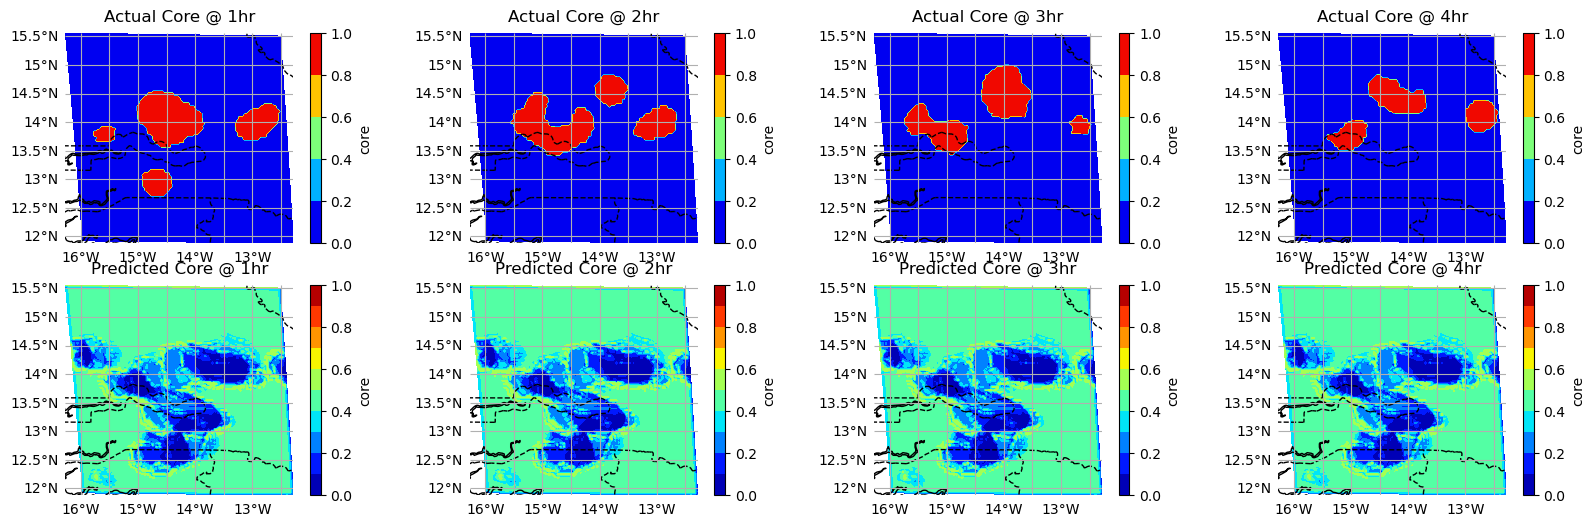

In [34]:
day = 6-2
data = np.zeros((day,image_height,image_width))
for x in range(0,4,1):
    data[x] = np.squeeze(pred_frames[x,:,:,0])
        
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.1)]  #[0, 0.1, 0.2, 0.3,0.4]]
#levels_custom=[[0, 0.5 ,1],[0, 0.5 ,1]]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()